In [76]:
from reduction import *

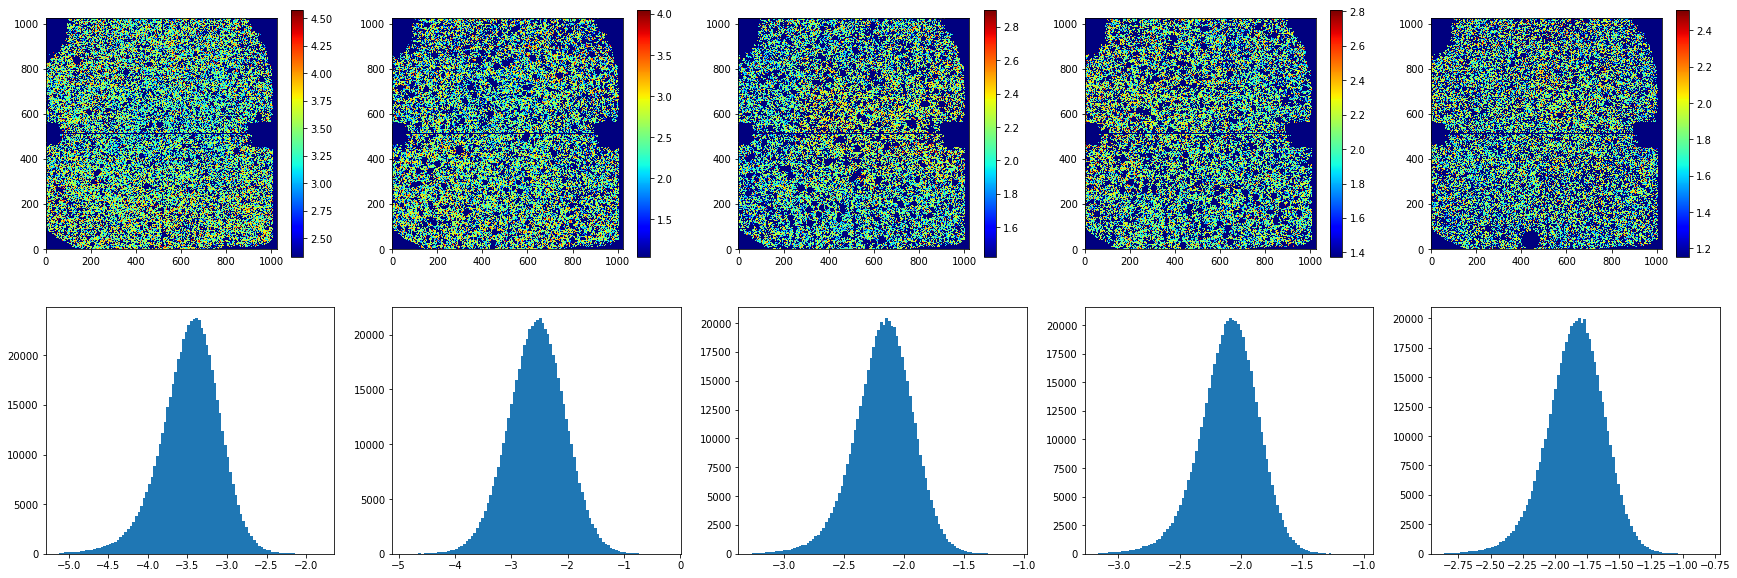

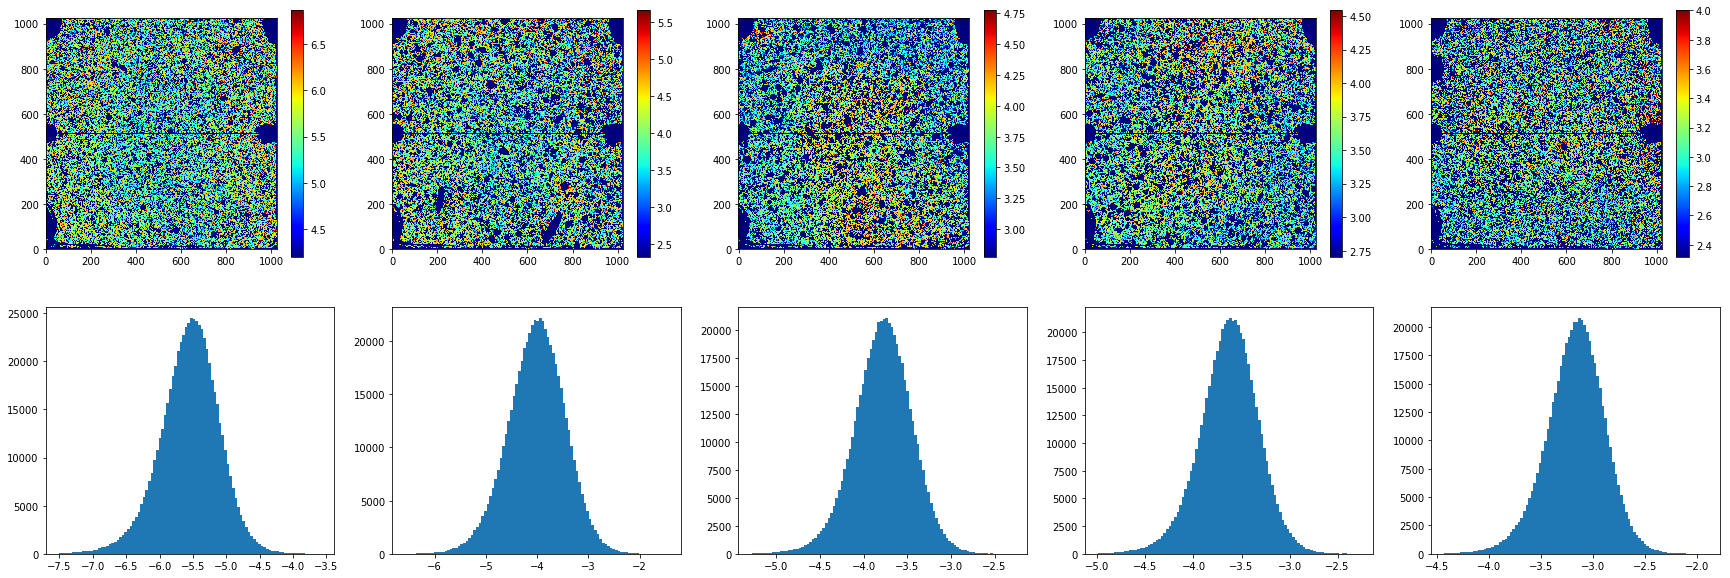

In [77]:
for inst in [1,2]:
    data = image_reduction(inst)
    fig, ax = plt.subplots(2,5, figsize=(30,10))
    for ifield in [4,5,6,7,8]:
        mapin = data.stackmapdat[ifield]['map'].copy()
        strmask = data.stackmapdat[ifield]['strmask'].copy()
        mask_inst = data.stackmapdat[ifield]['mask_inst'].copy()
        ax[1][ifield-4].hist(mapin[strmask*mask_inst==1],bins=100)
        imageclip(-mapin*strmask*mask_inst,ax=ax[0][ifield-4])

# Calibration from 2MASS Photometry

/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils_plotting.py:78: RuntimeWarning: invalid value encountered in greater_equal
  spp = np.where(y>=0)[0]
/Users/ytcheng/ciber/python_ciber/stack_modelfit/utils_plotting.py:79: RuntimeWarning: invalid value encountered in less
  spn = np.where(y<0)[0]
/Users/ytcheng/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:103: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


band 1 apf2nWpm2psr:

4:-447.43, 5:-335.72, 6:-460.06, 7:-333.67, 8:-375.62


band 2 apf2nWpm2psr:

4:-121.83, 5:-117.72, 6:-137.77, 7:-111.20, 8:-115.38




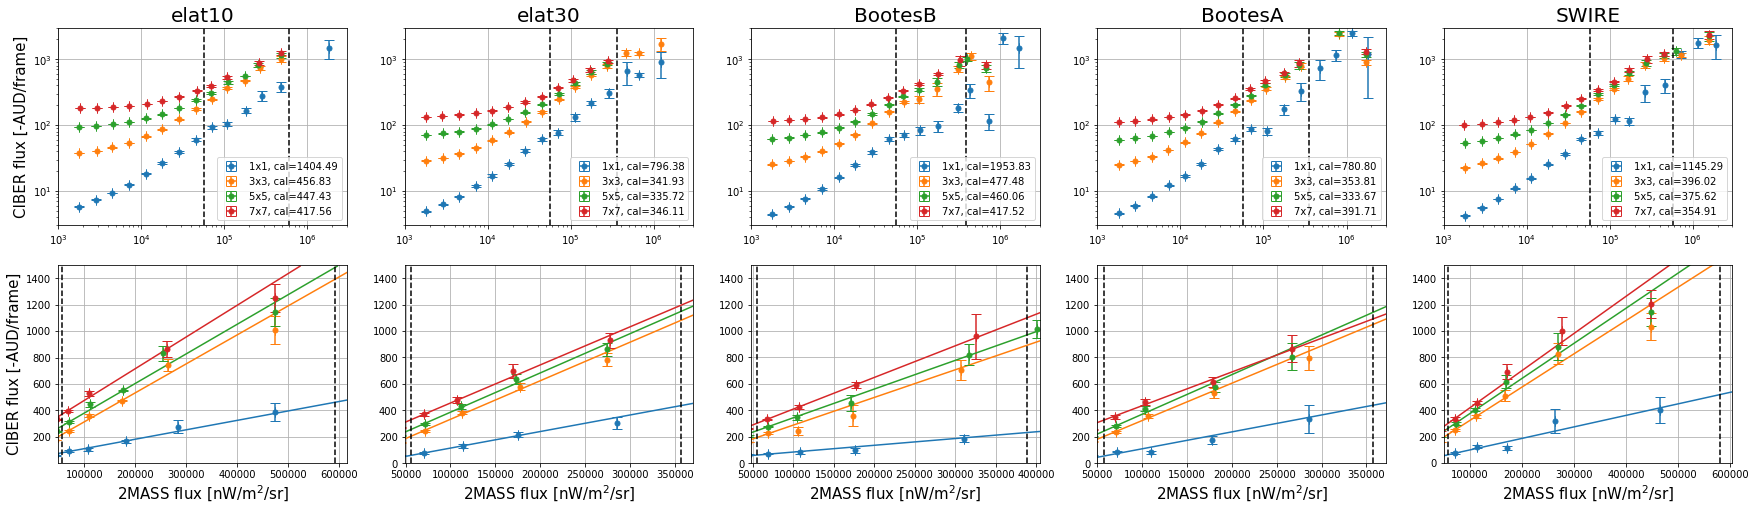

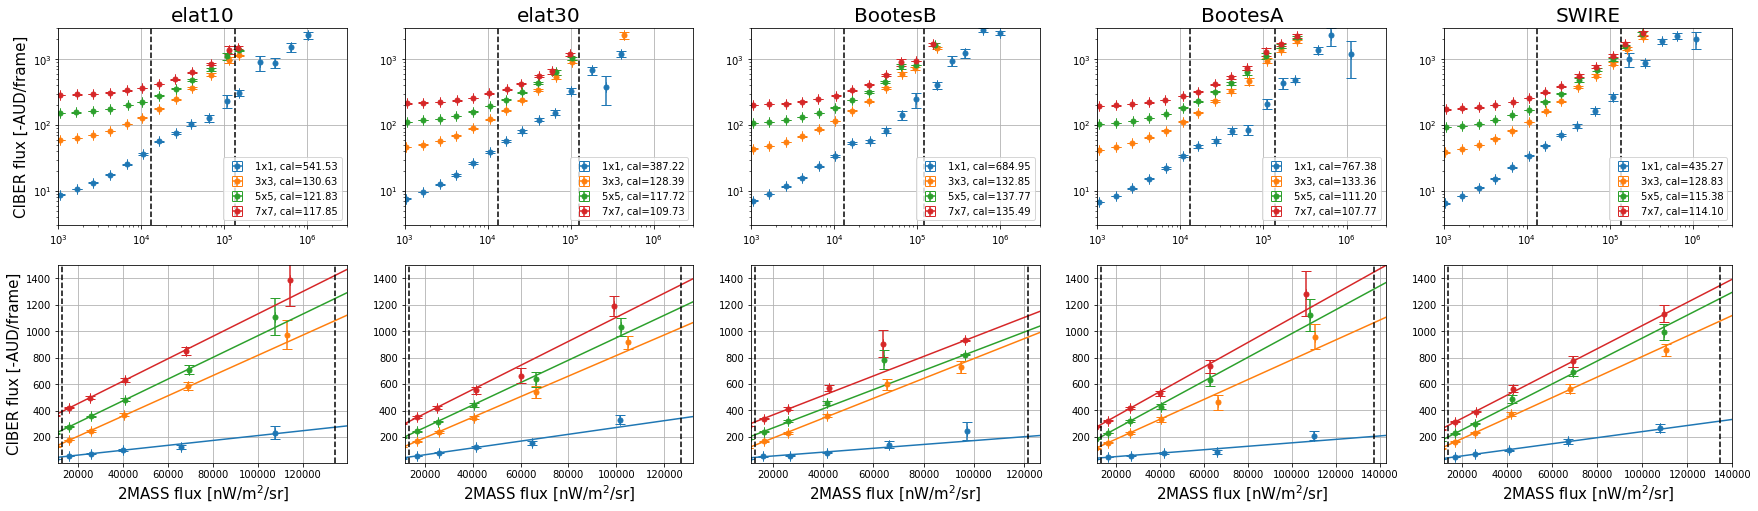

In [79]:
from reduction import *

for inst in [1,2]:
    data = image_reduction(inst)
    if inst==1:
        fitmaglim = (10.5,13)
    else:
        fitmaglim = (11.5,14)
    
    calfac = []
    fig, ax = plt.subplots(2,5,figsize=(30,8))
    for ifield in [4,5,6,7,8]:

        mapin = -data.stackmapdat[ifield]['map'].copy()
        mask_inst =  data.stackmapdat[ifield]['mask_inst'].copy()
        strnum = data.stackmapdat[ifield]['strnum'].copy()

        df = pd.read_csv(mypaths['2Mcatdat'] + fieldnamedict[ifield] + '.csv')
        xs, ys = np.array(df['y'+str(inst)]), np.array(df['x'+str(inst)])
        ms = np.array(df['I']) if inst==1 else np.array(df['H'])

        sp = np.where((xs>=3) & (xs<1020) & (ys>=3) & (ys<1020))[0]
        xs, ys, ms = xs[sp], ys[sp], ms[sp]
        Is = ABmag2Iciber(inst, ms)

        mbinedges = np.arange(9,17.5,0.5)
        mbins = (mbinedges[1:] + mbinedges[:-1]) / 2
        stampsize_arr = np.array([1,3,5,7])

        Ith_arr = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Icb_arr = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Ith_err = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        Icb_err = np.zeros([len(stampsize_arr),len(mbinedges)-1])
        for im, (m_min, m_max) in enumerate(zip(mbinedges[:-1], mbinedges[1:])):

            msp = np.where((ms >= m_min) & (ms < m_max))[0]    
            for ist, stampsize in enumerate(stampsize_arr):

                Iths, Icbs = [], []
                for x,y,m,I in zip(xs[msp], ys[msp], ms[msp], Is[msp]):
                    x, y = int(round(x)), int(round(y))
                    xmin, xmax = x-stampsize//2, x+stampsize//2
                    ymin, ymax = y-stampsize//2, y+stampsize//2

                    if np.any(mask_inst[xmin:xmax+1,ymin:ymax+1]==0):
                        continue

                    Iths.append(I)
                    Icbs.append(np.sum(mapin[xmin:xmax+1,ymin:ymax+1]))

                Iths, Icbs = np.array(Iths), np.array(Icbs)
                if len(Iths)==0:
                    continue

                Q1 = np.percentile(Icbs, 25)
                Q3 = np.percentile(Icbs, 75)
                clipmin = Q1 - 3 * (Q3 - Q1)
                clipmax = Q3 + 3 * (Q3 - Q1)
                spclip = np.where((Icbs > clipmin) & (Icbs < clipmax))[0]
                Iths, Icbs = Iths[spclip], Icbs[spclip]
                if len(Iths)==0:
                    continue

                Ith_arr[ist, im] = np.mean(Iths)
                Icb_arr[ist, im] = np.mean(Icbs)
                Ith_err[ist, im] = np.std(Iths)/np.sqrt(len(Iths))
                Icb_err[ist, im] = np.std(Icbs)/np.sqrt(len(Icbs))

        Ith_arr[Ith_arr==0] = np.nan
        Icb_arr[Icb_arr==0] = np.nan
        Ith_err[Ith_arr==0] = np.nan
        Icb_err[Icb_arr==0] = np.nan

        Fth_arr = Iciber2FJy(inst, Ith_arr)
        Fth_err = Iciber2FJy(inst, Ith_err)

        for ist, stampsize in enumerate(stampsize_arr):
            spfit = np.where((mbins > fitmaglim[0]) & (mbins < fitmaglim[1])\
                             & (Fth_arr[ist]==Fth_arr[ist]))[0]
            fitparam = np.polyfit(Icb_arr[ist,spfit], Ith_arr[ist,spfit], w=1/Icb_err[ist,spfit], deg=1)
            yfit = np.logspace(np.log10(np.nanmin(Icb_arr)), np.log10(np.nanmax(Icb_arr)), 100)
            xfit = fitparam[0]*yfit + fitparam[1]
            if stampsize ==5:
                calfac.append(fitparam[0])
            plot_err_log(Ith_arr[ist], Icb_arr[ist], Icb_err[ist], xerr=Fth_err[ist],
                         ax=ax[0][ifield-4], color='C'+str(ist),
                         label='%dx%d, cal=%.2f'%(stampsize,stampsize,fitparam[0]))
            plot_err_log(Ith_arr[ist], Icb_arr[ist], Icb_err[ist], xerr=Fth_err[ist],
                         ax=ax[1][ifield-4], color='C'+str(ist),
                         label='%dx%d, cal=%.2f'%(stampsize,stampsize,fitparam[0]))
            ax[1][ifield-4].plot(xfit, yfit, color='C'+str(ist))

        ax[0][ifield-4].axvline(Ith_arr[0,spfit[0]]*1.25, c='k', ls='--')
        ax[0][ifield-4].axvline(Ith_arr[0,spfit[-1]]*0.8, c='k', ls='--')
        ax[1][ifield-4].axvline(Ith_arr[0,spfit[0]]*1.25, c='k', ls='--')
        ax[1][ifield-4].axvline(Ith_arr[0,spfit[-1]]*0.8, c='k', ls='--')

        ax[0][ifield-4].legend(loc=4)
        ax[0][ifield-4].grid()
        ax[0][ifield-4].set_xlim([1e3, 3e6])
        ax[0][ifield-4].set_ylim([3e0, 3e3])
        ax[0][ifield-4].set_title(fieldnamedict[ifield], fontsize=20)

        ax[1][ifield-4].grid()
        ax[1][ifield-4].set_xlim([Ith_arr[0,spfit[-1]]*0.7, Ith_arr[0,spfit[0]]*1.3])
        ax[1][ifield-4].set_ylim([0, 1500])
        ax[1][ifield-4].set_xlabel('2MASS flux [nW/m$^2$/sr]', fontsize=15)
        ax[1][ifield-4].set_xscale('linear')
        ax[1][ifield-4].set_yscale('linear')
    ax[0][0].set_ylabel('CIBER flux [-AUD/frame]', fontsize=15)
    ax[1][0].set_ylabel('CIBER flux [-AUD/frame]', fontsize=15)
    
    plt.savefig('plots/paperfig/calfac_TM%d.png'%(inst), dpi = 200, bbox_inches='tight')
    
    print('band %d apf2nWpm2psr:\n'%inst)
    for i,ifield in enumerate([4,5,6,7,8]):
        if i!=0:
            print(', ', end='')
        print('%d:-%.2f'%(ifield,calfac[i]), end='')
    print('\n\n')

The cal factors are copy paste to ciber_info.py

# PSF model

In [1]:
from reduction import *

In [106]:
inst = 1
fname = mypaths['alldat'] + 'TM'+ str(inst) + '/psfdata.pkl'
with open(fname,"rb") as f:
    psfdata = pickle.load(f)

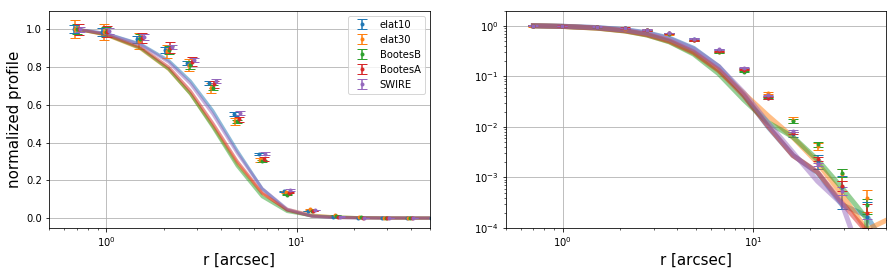

In [103]:
fig, ax = plt.subplots(1,2,figsize=(15,4))

for ifield in [4,5,6,7,8]:
    rbins = psfdata[ifield]['rbins']
    
    psf_map = restoration.richardson_lucy\
    (psfdata[ifield]['stackmap']/np.sum(psfdata[ifield]['stackmap']), pix_map, 10)
    psfprof = radial_prof(psf_map)['prof']
        
    ax[0].errorbar(rbins*(1+(ifield-6)*0.02),
                 psfdata[ifield]['prof']/psfdata[ifield]['prof'][0],
                 psfdata[ifield]['prof_err']/psfdata[ifield]['prof'][0],
                 c='C'+str(ifield-4),fmt ='.', capsize=5, label=fieldnamedict[ifield])
    ax[0].semilogx(rbins,psfprof/psfprof[0],
                   lw=3,alpha=0.5,c='C'+str(ifield-4))
    
    ax[1].errorbar(rbins,
                 psfdata[ifield]['prof']/psfdata[ifield]['prof'][0],
                 psfdata[ifield]['prof_err']/psfdata[ifield]['prof'][0],
                 c='C'+str(ifield-4),fmt ='.', capsize=5)
    ax[1].semilogx(rbins,psfprof/psfprof[0],'-',lw=5,alpha=0.5,c='C'+str(ifield-4))

ax[1].set_yscale('log')
ax[0].set_xlim([5e-1,50])
ax[1].set_xlim([5e-1,50])
ax[1].set_ylim([1e-4,2])
ax[0].legend()
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('r [arcsec]', fontsize=15)
ax[1].set_xlabel('r [arcsec]', fontsize=15)
ax[0].set_ylabel('normalized profile', fontsize=15)
plt.savefig('plots/paperfig/psf_TM%d.png'%(inst), dpi = 200, bbox_inches='tight')

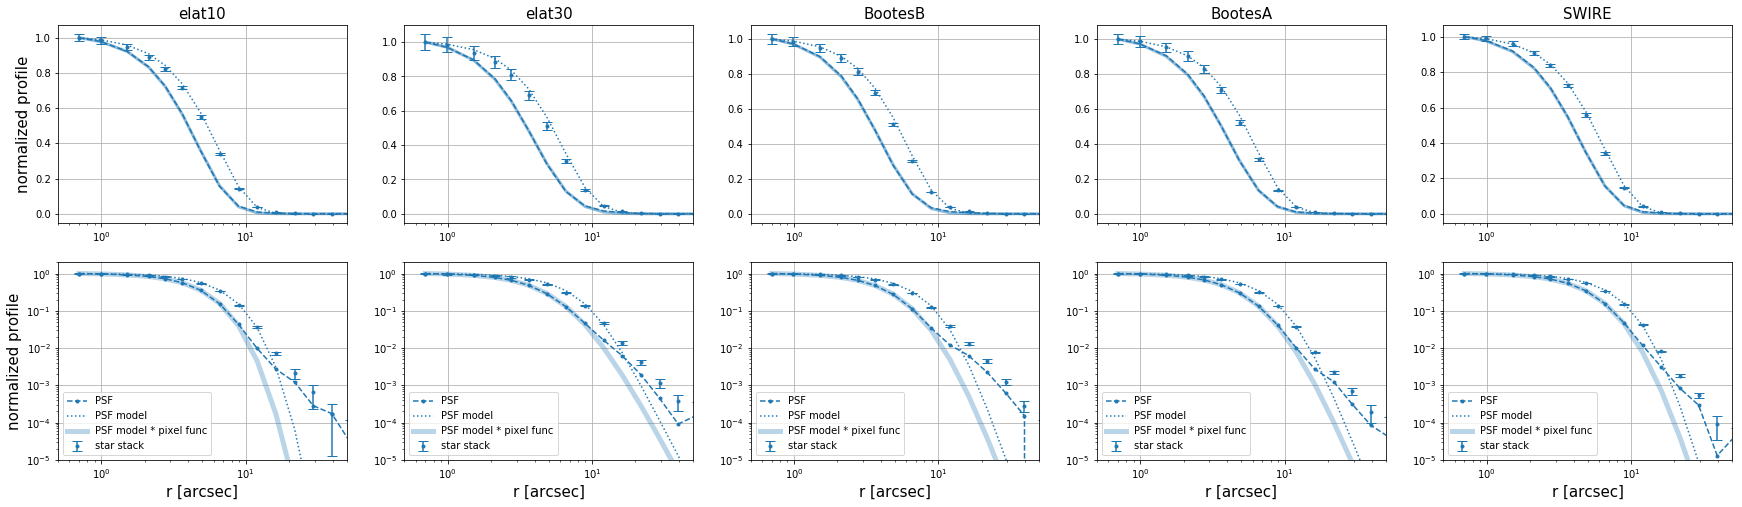

In [104]:
from scipy.optimize import curve_fit

dx = 1200
def beta_function(r, beta, rc, norm):
    return norm * (1 + (r / rc)**2)**(-3.*beta/2)

pix_map = data._pix_func_substack()

fig, ax = plt.subplots(2,5,figsize=(30,8))
for i,ifield in enumerate([4,5,6,7,8]):
    rbins = psfdata[ifield]['rbins']
    
    psf_map = restoration.richardson_lucy\
    (psfdata[ifield]['stackmap']/np.sum(psfdata[ifield]['stackmap']), pix_map, 10)
    psfprof = radial_prof(psf_map)['prof']
    
    (beta, rc, norm), _ = curve_fit(beta_function, rbins[rbins < 30]
                        ,psfprof[rbins < 30]/psfprof[0])
    psfprofbeta = beta_function(rbins, beta, rc, norm)
    
    radmap = make_radius_map(np.zeros([2*dx+1, 2*dx+1]),dx, dx)*0.7
    psf_map_beta = beta_function(radmap, beta, rc, norm)
    psf_map_conv = fftconvolve(psf_map_beta, pix_map, 'same')
    psfprofconv = radial_prof(psf_map_conv)['prof']
    
    ax[0][i].errorbar(rbins,
                 psfdata[ifield]['prof']/psfdata[ifield]['prof'][0],
                 psfdata[ifield]['prof_err']/psfdata[ifield]['prof'][0],
                 c='C0',fmt ='.', capsize=5)
    ax[0][i].semilogx(rbins,psfprof/psfprof[0],'--',c='C0')
    ax[0][i].semilogx(rbins,psfprofconv/psfprofconv[0],':',c='C0')
    ax[0][i].semilogx(rbins,psfprofbeta/psfprofbeta[0],'-',lw=3,alpha=0.5,c='C0')

    ax[1][i].errorbar(rbins,
                 psfdata[ifield]['prof']/psfdata[ifield]['prof'][0],
                 psfdata[ifield]['prof_err']/psfdata[ifield]['prof'][0],
                 c='C0',fmt ='.', capsize=5, label='star stack')
    ax[1][i].semilogx(rbins,psfprof/psfprof[0],'--.',c='C0', label='PSF')
    ax[1][i].semilogx(rbins,psfprofconv/psfprofconv[0],':',c='C0', label='PSF model')
    ax[1][i].semilogx(rbins,psfprofbeta/psfprofbeta[0],
                   lw=5,alpha=0.3,c='C0', label='PSF model * pixel func')
    
    ax[1][i].set_yscale('log')
    ax[0][i].set_xlim([5e-1,50])
    ax[1][i].set_xlim([5e-1,50])
    ax[1][i].set_ylim([1e-5,2])
    ax[1][i].legend()
    ax[0][i].set_title(fieldnamedict[ifield], fontsize=15)
    ax[0][i].grid()
    ax[1][i].grid()
    ax[1][i].set_xlabel('r [arcsec]', fontsize=15)
ax[0][0].set_ylabel('normalized profile', fontsize=15)
ax[1][0].set_ylabel('normalized profile', fontsize=15)
plt.savefig('plots/paperfig/psf_rec_TM%d.png'%(inst), dpi = 200, bbox_inches='tight')

# check z range fo MICECAT, hidden valley

# rerun MICECAT w/ mag correction